In [76]:
import matplotlib.pyplot as plt
import numpy as np

In [77]:
def gather_results(filename):
    """Get the results from a .txt file and format into dictionary"""
    results = {}
    with open(filename, "r") as file:
        for line in file.readlines():
            seconds = float(line.split(": ")[-1])
            prompt = int(line.split(": ")[0].split(" ")[-1])
            results[prompt] = results.get(prompt, []) + [seconds]
    return results

In [78]:
def truncate(results, n=0.5, n_type="proportion"):
    """Remove the best and worst times for each prompt length"""
    if n_type == "absolute" and n % 2:
        raise ValueError("If n_type is absolute, then n must be even")
    if n_type == "proportion" and (n > 1 or n < 0):
        raise ValueError("If n_type is proportion then n must be between 0 and 1")

    truncated_results = {}
    for key, vals in results.items():
        total_to_truncate = n if n_type == "absolute" else len(vals) * n
        truncate_index = int(total_to_truncate // 2)
        truncated_results[key] = sorted(vals)[truncate_index:-truncate_index]
    return truncated_results

In [79]:
def plot_times(results, color, label=None, title=None):
    """Plot the times for token generation time with different prompts"""
    if type(results) == dict:
        means, bounds = {}, {}
        for key in sorted(results.keys()):
            vals = sorted(results[key])
            mean, stdv = np.mean(vals), np.std(vals)
            means[key], bounds[key] = mean, (mean - stdv, mean + stdv)
        fill_kwargs = {"alpha": 0.4, "color": color, "linewidth": 0}
        plt.fill_between(means.keys(), *zip(*bounds.values()), **fill_kwargs)
        plt.plot(*zip(*means.items()), color=color)
        plt.scatter(*zip(*means.items()), color=color, label=label)
    else:
        plt.plot(*results, color=color, label=label, linestyle="dashed")
    plt.xlabel("Prompt Length (tokens)")
    plt.ylabel("Generation Time (seconds/token)")
    if title:
        plt.title(title)

In [80]:
def calculate_line_of_best_fit(results):
    """Determine the line of best fit given the results"""
    data_points = []
    for key, vals in results.items():
        data_points += [(key, val) for val in vals]
    samples = range(max(results.keys()))
    best_fit = {}
    best_fit["eq"] = np.poly1d(np.polyfit(*zip(*data_points), 1))
    best_fit["samples"] = (samples, best_fit["eq"](samples))
    best_fit["intercept"] = best_fit["eq"]([0])
    best_fit["slope"] = best_fit["eq"]([1]) - best_fit["eq"]([0])
    return best_fit

In [81]:
results = gather_results("gpu-kv_f16-llama-2-7b-Q8_0.txt")
truncated_results = truncate(results, n=0.5)
best_fit = calculate_line_of_best_fit(truncated_results)
best_fit_eq = str(best_fit["eq"])[2:]
title = f"Line of Best Fit = {best_fit_eq}"

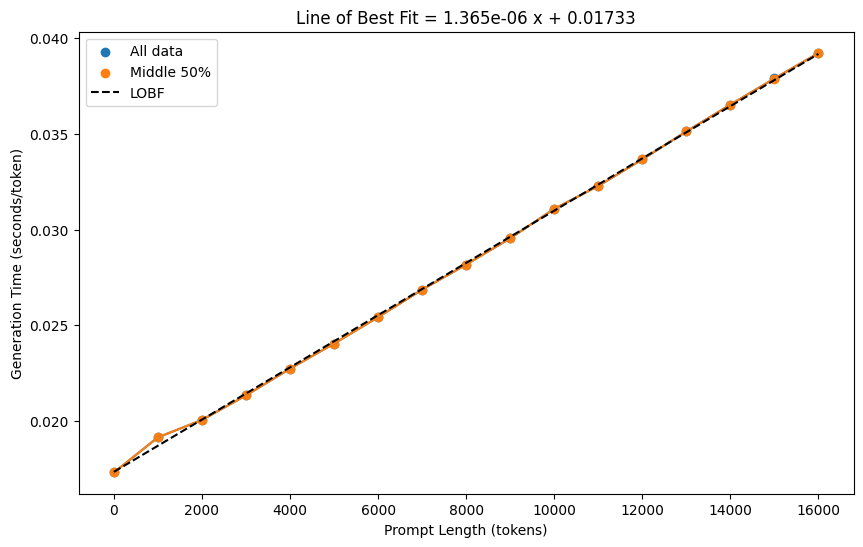

In [82]:
plt.figure(figsize=(10, 6))

plot_times(results, "C0", "All data")
plot_times(truncated_results, "C1", "Middle 50%")
plot_times(best_fit["samples"], "k", "LOBF", title)

plt.legend(loc=2)
plt.savefig("gpu-example-generation.png", dpi=400)
plt.show()

In [83]:
def attention_proportion(results, intercept):
    """Calculate the proportion of time that is spent in attention"""
    if type(results) == dict:
        proportions = {}
        for key, vals in results.items():
            proportions[key] = [(val - intercept) / val for val in vals]
    else:
        keys, vals = results
        proportions = (keys, [(val - intercept) / val for val in vals])
    return proportions


def plot_proportion(results, color, label=None, title=None):
    """Plot the proportion of time spent in attention"""
    if type(results) == dict:
        means, bounds = {}, {}
        for key in sorted(results.keys()):
            vals = sorted(results[key])
            mean, stdv = np.mean(vals), np.std(vals)
            means[key], bounds[key] = mean, (mean - stdv, mean + stdv)
        fill_kwargs = {"alpha": 0.4, "color": color, "linewidth": 0}
        plt.fill_between(means.keys(), *zip(*bounds.values()), **fill_kwargs)
        plt.plot(*zip(*means.items()), color=color, label=label, linewidth=2)
        # plt.scatter(*zip(*means.items()), color=color, label=label)
    else:
        plt.plot(*results, color=color, label=label, linestyle="dashed")
    plt.xlabel("Prompt Length (tokens)")
    plt.ylabel("Proportion of time in attention")
    plt.grid()
    if title:
        plt.title(title)

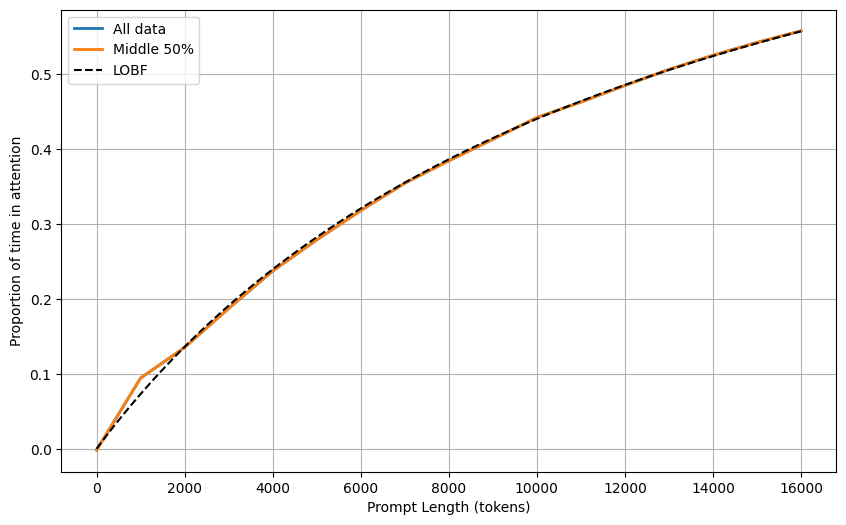

In [84]:
plt.figure(figsize=(10, 6))

proportion_results = attention_proportion(results, best_fit["intercept"])
proportion_truncated_results = attention_proportion(truncated_results, best_fit["intercept"])
proportion_lobf = attention_proportion(best_fit["samples"], best_fit["intercept"])

plot_proportion(proportion_results, "C0", "All data")
plot_proportion(proportion_truncated_results, "C1", "Middle 50%")
plot_proportion(proportion_lobf, "k", "LOBF")

plt.legend(loc=2)
plt.savefig("gpu-example-proportion.png", dpi=400)
plt.show()

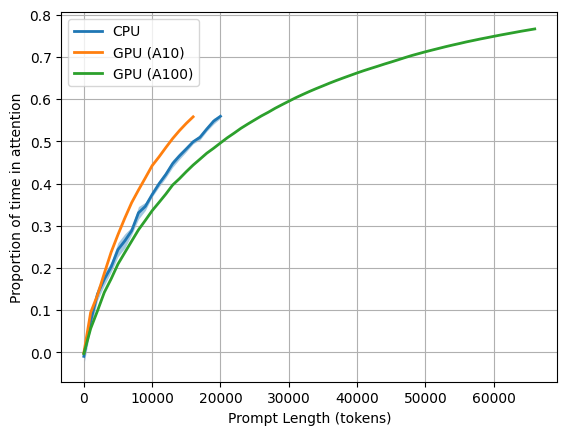

In [85]:
configs = {
    "CPU": {
        "logs": "cpu-kv_f16-llama-2-7b-Q8_0.txt",
        "color": "C0",
    },
    "GPU (A10)": {
        "logs": "gpu-kv_f16-llama-2-7b-Q8_0.txt",
        "color": "C1",
    },
    "GPU (A100)": {
        "logs": "a100-kv_f16-llama-2-7b-Q8_0.txt",
        "color": "C2",
    },
}

for config in configs:
    results = truncate(gather_results(configs[config]["logs"]), n=0.5)
    best_fit = calculate_line_of_best_fit(results)
    proportion = attention_proportion(results, best_fit["intercept"])
    plot_proportion(proportion, configs[config]["color"], config)



# cpu_results = truncate(gather_results("cpu-kv_f16-llama-2-7b-Q8_0.txt"), n=0.5)
# gpu_results = truncate(gather_results("gpu-kv_f16-llama-2-7b-Q8_0.txt"), n=0.5)

# cpu_best_fit = calculate_line_of_best_fit(cpu_results)
# gpu_best_fit = calculate_line_of_best_fit(gpu_results)

# cpu_proportion = attention_proportion(cpu_results, cpu_best_fit["intercept"])
# gpu_proportion = attention_proportion(gpu_results, gpu_best_fit["intercept"])


# plot_proportion(cpu_proportion, "C0", "CPU")
# plot_proportion(gpu_proportion, "C1", "GPU (A10)")



plt.legend(loc=2)
# plt.xlim([-500, 17000])
# plt.ylim([-0.05, 0.6])
plt.savefig("hardware-comparison.png", dpi=400)
plt.show()

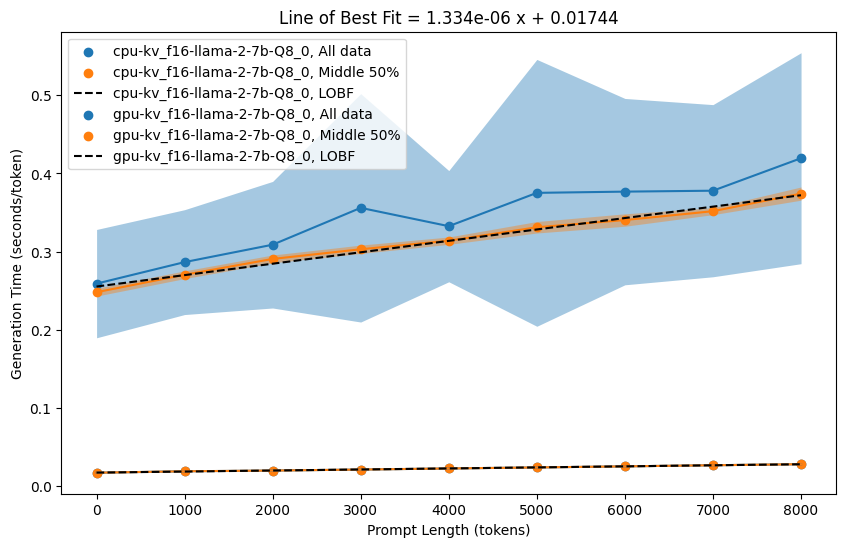

In [86]:
plt.figure(figsize=(10, 6))


for file in ["cpu-kv_f16-llama-2-7b-Q8_0", "gpu-kv_f16-llama-2-7b-Q8_0"]:
    results = gather_results(f"{file}.txt")
    remove_list = []
    for key in results:
        if key > 8000:
            remove_list += [key]
    for key in remove_list:
        del results[key]
    truncated_results = truncate(results, n=0.5)
    best_fit = calculate_line_of_best_fit(truncated_results)
    best_fit_eq = str(best_fit["eq"])[2:]
    title = f"Line of Best Fit = {best_fit_eq}"


    plot_times(results, "C0", f"{file}, All data")
    plot_times(truncated_results, "C1", f"{file}, Middle 50%")
    plot_times(best_fit["samples"], "k", f"{file}, LOBF", title)

plt.legend(loc=2)
plt.show()